# P1dB Measurement

ADC saturates when high power came to ADC (Not DAC). You can get P1dB of gain with this code.

## QICK Pyro Instantiation

In [1]:
import numpy as np
import matplotlib.pyplot as plt

from qick import *
from qick.averager_program import QickSweep, merge_sweeps
from qick.asm_v1 import QickRegister
from qick.pyro import make_proxy

# Qick version : 0.2.357
(soc, soccfg) = make_proxy("192.168.2.99")
# Set DAC Channel 0 attenuation 20 dB and 20 dB, and turn on DAC channel
soc.rfb_set_gen_rf(0,10,10)
# Set DAC Channel filter as bypass mode
soc.rfb_set_gen_filter(0,fc = 2.5, ftype = "lowpass")
# Set ADC Channel attenuation 20 dB, and turn on ADC channel
soc.rfb_set_ro_rf(0,10)
# Set ADC Channel filter as bypass mode
soc.rfb_set_ro_filter(0, fc = 2.5, ftype = "lowpass")

Pyro.NameServer PYRO:Pyro.NameServer@0.0.0.0:8888
myqick PYRO:obj_9d369bee84084fc19b57abe94672fcca@192.168.2.99:42971


## Single Frequency P1dB Measurement Program

C:\Users\Measurement6\AppData\Local\Temp\ipykernel_30224\1355845054.py:77: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap("tab10", len(freq_rf))


  0%|          | 0/50000 [00:00<?, ?it/s]

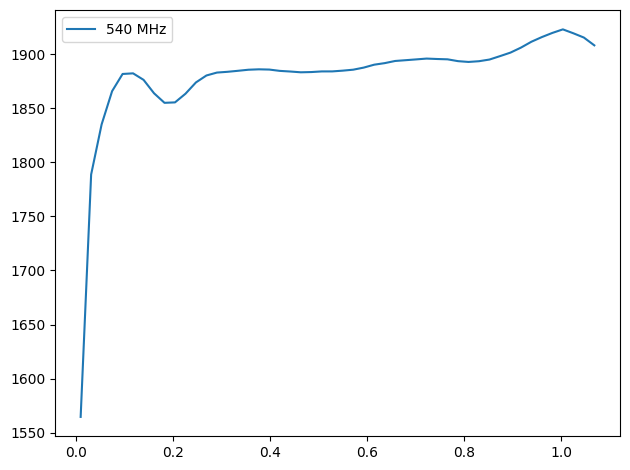

In [2]:
class P1dBMeas_Exp(NDAveragerProgram):
    def initialize(self):
        cfg = self.cfg
        freq_rf     = cfg["freq_rf"]
        # Declare RF generation channel
        self.declare_gen(
            ch      = 0,        # Channel
            nqz     = 1         # Nyquist Zone
        )
        # Declare RF input channel
        self.declare_readout(
            ch      = 0,        # Channel
            length  = cfg["pulse_time"] + 100       # Readout length
        )
        self.r_gain  = self.get_gen_reg(gen_ch = 0, name = "gain")
        self.add_sweep(
            QickSweep(
                prog    = self,
                reg     = self.r_gain,
                start   = 300,
                stop    = 35000,
                expts   = 50,
                label   = "gain_sweep"
            )
        )

        # Convert RF frequency to DAC DDS register value
        freq_dac    = self.freq2reg(
            f       = freq_rf,  # Frequency
            gen_ch  = 0,        # Generator channel
            ro_ch   = 0         # Readout channel for round up
        )
        # Convert RF frequency to ADC DDS register value
        freq_adc    = self.freq2reg_adc(
            f       = freq_rf,  # Frequency
            ro_ch   = 0,        # Readout channel
            gen_ch  = 0         # Generator channel for round up
        )

        # Set DAC DDS
        self.set_pulse_registers(
            ch      = 0,        # Generator channel
            style   = "const",  # Output is gain * DDS output
            freq    = freq_dac, # Generator DDS frequency
            phase   = 0,        # Generator DDS phase
            gain    = 5000,     # Generator amplitude
            length  = cfg["pulse_time"],       # Pulse length
            phrst   = 0         # Generator DDS phase reset
        )
        # Set ADC DDS
        self.set_readout_registers(
            ch      = 0,        # Readout channel
            freq    = freq_adc, # Readout DDS frequency
            length  = cfg["pulse_time"],       # Readout DDS multiplication length
            phrst   = 0         # Readout DDS phase reset
        )
        self.synci(100)
    def body(self):
        self.pulse(
            ch      = 0,        # Generator channel
            t       = 50        # Pulse will be output @ sync_t + 100
        )
        self.readout(
            ch      = 0,        # Readout channel
            t       = 50        # Readout DDS will start multiplication
                                # @ sync_t + 100
        )
        self.trigger(
            adcs    = [0],      # Readout channels
            adc_trig_offset = 150 # Readout will capture the data @ sync_t + 50
        )
        self.sync_all(1000)

freq_rf = [
    540
]
cmap = plt.cm.get_cmap("tab10", len(freq_rf))
plt.figure()
for i, f in enumerate(freq_rf):
    cfg = {
        # Experiment Setup
        "reps" : 1000,
        "expts" : 1,
        "freq_sweep_num" : 100,
        "duration_sweep_num" : 100,
        # Parameter Setup
        "freq_rf" : f,
        "pulse_time" : 4000
    }
    prog = P1dBMeas_Exp(
        soccfg, # Note that it should be QickSocConfig, not the QickSoc
        cfg
    )
    expt_pts, avg_di, avg_dq = prog.acquire(soc, progress=True)
    meas_pwr = np.sqrt(avg_di[0][0] * avg_di[0][0] + avg_dq[0][0] * avg_dq[0][0])

    plt.plot(expt_pts[0]/32768, meas_pwr, color=cmap(i))
plt.tight_layout()
plt.legend([f"{f} MHz" for f in freq_rf])
plt.show()

## Multi Frequency P1dB Measurement


// Program

        regwi 0, $22, 89478485;                 //freq = 89478485
        regwi 0, $23, 0;                        //phase = 0
        regwi 0, $25, 5000;                     //gain = 5000
        regwi 0, $26, 591824;                   //phrst| stdysel | mode | | outsel = 0b01001 | length = 2000 
        regwi 4, $22, 178956970;                //freq = 178956970
        regwi 4, $26, 2000;                     //mode | outsel = 0b00000 | length = 2000 
        synci 100;
        regwi 0, $13, 0;
        regwi 0, $14, 499;
LOOP_I: regwi 0, $15, 999;
LOOP_J: regwi 0, $27, 100;                      //t = 100
        set 0, 0, $22, $23, $0, $25, $26, $27;  //ch = 0, pulse @t = $27
        regwi 4, $27, 100;                      //t = 100
        set 4, 4, $22, $0, $26, $0, $26, $27;   //ch = 0, pulse @t = $27
        regwi 0, $16, 1;                        //out = 0b0000000000000001
        seti 7, 0, $16, 50;                     //ch =0 out = $16 @t = 0
        seti 7, 0, $0, 

  0%|          | 0/500000 [00:00<?, ?it/s]

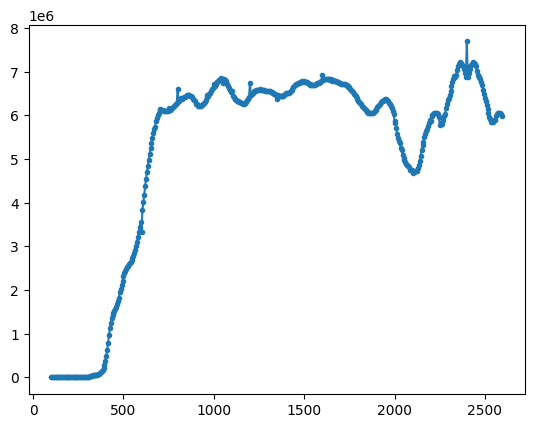

In [3]:
RegisterType = ["freq", "time", "phase", "adc_freq"]
MHz = 1

class P1dB_Meas(RAveragerProgram):
    def initialize(self):
        freq_rf     = self.cfg["start"]
        # Declare RF generation channel
        self.declare_gen(
            ch      = 0,        # Channel
            nqz     = 2         # Nyquist Zone
        )

        # Declare RF input channel
        self.declare_readout(
            ch      = 0,        # Channel
            length  = self.cfg["pulse_time"] + 100      # Readout length
        )

        # Convert RF frequency to DAC DDS register value
        freq_dac    = self.freq2reg(
            f       = freq_rf,  # Frequency
            gen_ch  = 0,        # Generator channel
            ro_ch   = 0         # Readout channel for round up
        )

        # Convert RF frequency to ADC DDS register value
        freq_adc    = self.freq2reg_adc(
            f       = freq_rf,  # Frequency
            ro_ch   = 0,        # Readout channel
            gen_ch  = 0         # Generator channel for round up
        )

        # Set DAC DDS
        self.set_pulse_registers(
            ch      = 0,        # Generator channel
            style   = "const",  # Output is gain * DDS output
            freq    = freq_dac, # Generator DDS frequency
            phase   = 0,        # Generator DDS phase
            gain    = 5000,     # Generator amplitude
            length  = self.cfg["pulse_time"],       # Pulse length
            phrst   = 0         # Generator DDS phase reset
        )

        # Set ADC DDS
        self.set_readout_registers(
            ch      = 0,        # Readout channel
            freq    = freq_adc, # Readout DDS frequency
            length  = self.cfg["pulse_time"],       # Readout DDS multiplication length
            phrst   = 0         # Readout DDS phase reset
        )
        self.synci(100)
        (self.ro_rp, self.ro_freq) = self._ro_regmap[0, "freq"]
        (self.gen_rp, self.gen_freq) = self._gen_regmap[0, "freq"]

    def body(self):
        self.pulse(
            ch      = 0,        # Generator channel
            t       = 100       # Pulse will be output @ sync_t + 100
        )

        self.readout(
            ch      = 0,        # Readout channel
            t       = 100       # Readout DDS will start multiplication
                                # @ sync_t + 100
        )
        self.trigger(
            adcs    = [0],      # Readout channels
            adc_trig_offset = 50 # Readout will capture the data @ sync_t + 50
        )
        self.sync_all(100)

    def update(self): 
        # Update readout frequency register 
        self.mathi(
            self.ro_rp, self.ro_freq, self.ro_freq, '+',
            self.freq2reg_adc(self.cfg["step"], 0, 0)
        )
        # Update generator frequency register
        self.mathi(
            self.gen_rp, self.gen_freq, self.gen_freq, '+',
            self.freq2reg(self.cfg["step"], 0, 0)
        )
        self.synci(10)

cfg = {
    # Experiment Setup
    "reps" : 1000,
    "freq_sweep_num" : 20,
    "duration_sweep_num" : 10,
    "start" : 100,
    "step" : 5,
    "expts" : 500,
    # Parameter Setup
    "pulse_time" : 2000
} 

prog = P1dB_Meas(
    soccfg,
    cfg
)
print(prog)
expts, avgi, avgq = prog.acquire(soc, progress = True)
plt.figure()
plt.plot(expts, avgi[0][0] * avgi[0][0] + avgq[0][0] * avgq[0][0], '.-')
plt.show()
